In [2]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions
using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("GridOperations.jl")
include("Topo.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Stefan Problem - test melting and solidification

Step 1 - import packages

Step 2 - Define a function that relates entropy and temperature/pressure. 
$$
T = f_1(P,S)
$$

$$
T = \exp \left( \frac{S}{C_V} + \ln (T_{ref}) - \frac{\Delta H_{fus} }{C_V T_M}X \right)
$$

and 
$$
S = f_2(P,T)
$$
$$
S = C_V (\ln (T) - \ln(T_{ref})) + \frac{\Delta H_{fus}}{T_m}X
$$

In [9]:
# functions that relates entropy and temperature/pressure are define in TemperatureEntropy.jl file
include("TemperatureEntropy.jl")

subgirdSdiff! (generic function with 1 method)


Step 3 - Write functions to set up the initial condition for the Stefan problem

- Consider a box with width 100 km and height 100 km.
- The box is filled entirely with one material
- Initially, the top 10 km is solid and the bottom 90 km is liquid.
- The sides are insulating
- Density is constant and equal to 1000 kg/m$^3$
- The surface is at T=100K, the bottom is at T=273 K
- The liquid is isothermal with $T=T_m$.
- The solid has initial $T(z)$ given by the Stefan solution (Turcotte and Schubert section 4.18)
$$
\theta = \frac{erf(\eta)}{erf(\lambda_1)}
$$
- Given the initial temperature, compute initial entropy S on the markers.
  

In [10]:
function initial_ice_depth(x::Float64)
    return options["ym"]
end 

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        new([0.0],[1e3],[0.0],[2.1e3],[2.2])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]
    mmat = markers.integers[markers.integerFields["material"],:]
    Threads.@threads for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end

function update_marker_T_X!(markers::Markers,materials::Materials,options::Dict)
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]    
    mmat = markers.integers[markers.integerFields["material"],:]
    Threads.@threads for i in 1:markers.nmark
        markers.scalars[T,i],markers.scalars[X,i] = compute_T_X_from_S((markers.scalars[S,i]),options)
    end
end

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    S = markers.scalarFields["S"]
    X = markers.scalarFields["X"]
    T = markers.scalarFields["T"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    rho = markers.scalarFields["rho"]
    
    # Setting up Stefan conidtion
    lambda1 = get_lambda1(options)
    t = get_t(lambda1,options)
    
    # Note: the melt fraction is defining our layers or ice and water.
    # water - X = 1.0 
    # ice - X = 0.0
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        
        if my > hice # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = 273.0
            markers.scalars[X,i] = 1.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
            markers.scalars[rho,i] = materials.rho0[1]
        elseif my < hice # icy shell
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = stefan_initial_condition(get_theta(my,t,lambda1),options)
            markers.scalars[X,i] = 0.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
            markers.scalars[rho,i] = materials.rho0[1]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + ((grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j]))*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

# Main part of code
- At each timestep, begin by computing T(S,X) on the markers
- Iteratively solve the temperature equation. Start with a guess S_new = S_old
    - For T_new, compute $q_{cond} = \nabla \cdot (k \nabla T_{new})$
    - Solve diffusion equation for S_new
    - Given S_new, update T_new
    - Iterate until converged...
- Given the new entropy solution on the cell centers, update the entropy and melt fraction on the markers.

  0.115715 seconds (2.66 M allocations: 40.970 MiB, 23.59% gc time)
1:1:0.0
Writing visualization file = max_debug8/markers.0000.vtp
  0.000158 seconds (2 allocations: 2.197 MiB)
2:1:0.0
3:1:0.0
4:1:0.0
5:1:0.0
6:1:0.0
7:1:0.0
8:1:0.0
9:1:0.0
10:1:0.0
11:1:0.0
12:1:0.0
13:1:0.0
14:1:0.0
15:1:0.0
16:1:0.0
17:1:0.0
18:1:0.0
19:1:0.0
20:1:0.0
21:1:0.0
22:1:0.0
23:1:0.0
24:1:0.0
25:1:0.0
26:1:0.0
27:1:0.0
28:1:0.0
29:1:0.0
30:1:0.0
31:1:0.0
32:1:0.0
33:1:0.0
34:1:0.0
35:1:0.0
36:1:0.0
37:1:0.0
38:1:0.0
39:1:0.0
40:1:0.0
41:1:0.0
42:1:0.0
43:1:0.0
44:1:0.0
45:1:0.0
46:1:0.0
47:1:0.0
48:1:0.0
49:1:0.0
50:1:0.0
51:1:0.0
52:1:0.0
53:1:0.0
54:1:0.0
55:1:0.0
56:1:0.0
57:1:0.0
58:1:0.0
59:1:0.0
60:1:0.0
61:1:0.0
62:1:0.0
63:1:0.0
64:1:0.0
65:1:0.0
66:1:0.0
67:1:0.0
68:1:0.0
69:1:0.0
70:1:0.0
71:1:0.0
72:1:0.0
73:1:0.0
74:1:0.0
75:1:0.0
76:1:0.0
77:1:0.0
78:1:0.0
79:1:0.0
80:1:0.0
81:1:0.0
82:1:0.0
83:1:0.0
84:1:0.0
85:1:0.0
86:1:0.0
87:1:0.0
88:1:0.0
89:1:0.0
90:1:0.0
91:1:0.0
92:1:0.0
93:1:0.0
9

739:1:0.0
740:1:0.0
741:1:0.0
742:1:0.0
743:1:0.0
744:1:0.0
745:1:0.0
746:1:0.0
747:1:0.0
748:1:0.0
749:1:0.0
750:1:0.0
751:1:0.0
752:1:0.0
753:1:0.0
754:1:0.0
755:1:0.0
756:1:0.0
757:1:0.0
758:1:0.0
759:1:0.0
760:1:0.0
761:1:0.0
762:1:0.0
763:1:0.0
764:1:0.0
765:1:0.0
766:1:0.0
767:1:0.0
768:1:0.0
769:1:0.0
770:1:0.0
771:1:0.0
772:1:0.0
773:1:0.0
774:1:0.0
775:1:0.0
776:1:0.0
777:1:0.0
778:1:0.0
779:1:0.0
780:1:0.0
781:1:0.0
782:1:0.0
783:1:0.0
784:1:0.0
785:1:0.0
786:1:0.0
787:1:0.0
788:1:0.0
789:1:0.0
790:1:0.0
791:1:0.0
792:1:0.0
793:1:0.0
794:1:0.0
795:1:0.0
796:1:0.0
797:1:0.0
798:1:0.0
799:1:0.0
800:1:0.0
801:1:0.0
Writing visualization file = max_debug8/markers.0008.vtp
  0.000203 seconds (2 allocations: 2.197 MiB)
802:1:0.0
803:1:0.0
804:1:0.0
805:1:0.0
806:1:0.0
807:1:0.0
808:1:0.0
809:1:0.0
810:1:0.0
811:1:0.0
812:1:0.0
813:1:0.0
814:1:0.0
815:1:0.0
816:1:0.0
817:1:0.0
818:1:0.0
819:1:0.0
820:1:0.0
821:1:0.0
822:1:0.0
823:1:0.0
824:1:0.0
825:1:0.0
826:1:0.0
827:1:0.0
828:1:0

1443:1:0.0
1444:1:0.0
1445:1:0.0
1446:1:0.0
1447:1:0.0
1448:1:0.0
1449:1:0.0
1450:1:0.0
1451:1:0.0
1452:1:0.0
1453:1:0.0
1454:1:0.0
1455:1:0.0
1456:1:0.0
1457:1:0.0
1458:1:0.0
1459:1:0.0
1460:1:0.0
1461:1:0.0
1462:1:0.0
1463:1:0.0
1464:1:0.0
1465:1:0.0
1466:1:0.0
1467:1:0.0
1468:1:0.0
1469:1:0.0
1470:1:0.0
1471:1:0.0
1472:1:0.0
1473:1:0.0
1474:1:0.0
1475:1:0.0
1476:1:0.0
1477:1:0.0
1478:1:0.0
1479:1:0.0
1480:1:0.0
1481:1:0.0
1482:1:0.0
1483:1:0.0
1484:1:0.0
1485:1:0.0
1486:1:0.0
1487:1:0.0
1488:1:0.0
1489:1:0.0
1490:1:0.0
1491:1:0.0
1492:1:0.0
1493:1:0.0
1494:1:0.0
1495:1:0.0
1496:1:0.0
1497:1:0.0
1498:1:0.0
1499:1:0.0
1500:1:0.0
1501:1:0.0
Writing visualization file = max_debug8/markers.0015.vtp
  0.000164 seconds (2 allocations: 2.197 MiB)
1502:1:0.0
1503:1:0.0
1504:1:0.0
1505:1:0.0
1506:1:0.0
1507:1:0.0
1508:1:0.0
1509:1:0.0
1510:1:0.0
1511:1:0.0
1512:1:0.0
1513:1:0.0
1514:1:0.0
1515:1:0.0
1516:1:0.0
1517:1:0.0
1518:1:0.0
1519:1:0.0
1520:1:0.0
1521:1:0.0
1522:1:0.0
1523:1:0.0
1524:1

2124:1:0.0
2125:1:0.0
2126:1:0.0
2127:1:0.0
2128:1:0.0
2129:1:0.0
2130:1:0.0
2131:1:0.0
2132:1:0.0
2133:1:0.0
2134:1:0.0
2135:1:0.0
2136:1:0.0
2137:1:0.0
2138:1:0.0
2139:1:0.0
2140:1:0.0
2141:1:0.0
2142:1:0.0
2143:1:0.0
2144:1:0.0
2145:1:0.0
2146:1:0.0
2147:1:0.0
2148:1:0.0
2149:1:0.0
2150:1:0.0
2151:1:0.0
2152:1:0.0
2153:1:0.0
2154:1:0.0
2155:1:0.0
2156:1:0.0
2157:1:0.0
2158:1:0.0
2159:1:0.0
2160:1:0.0
2161:1:0.0
2162:1:0.0
2163:1:0.0
2164:1:0.0
2165:1:0.0
2166:1:0.0
2167:1:0.0
2168:1:0.0
2169:1:0.0
2170:1:0.0
2171:1:0.0
2172:1:0.0
2173:1:0.0
2174:1:0.0
2175:1:0.0
2176:1:0.0
2177:1:0.0
2178:1:0.0
2179:1:0.0
2180:1:0.0
2181:1:0.0
2182:1:0.0
2183:1:0.0
2184:1:0.0
2185:1:0.0
2186:1:0.0
2187:1:0.0
2188:1:0.0
2189:1:0.0
2190:1:0.0
2191:1:0.0
2192:1:0.0
2193:1:0.0
2194:1:0.0
2195:1:0.0
2196:1:0.0
2197:1:0.0
2198:1:0.0
2199:1:0.0
2200:1:0.0
2201:1:0.0
Writing visualization file = max_debug8/markers.0022.vtp
  0.000154 seconds (2 allocations: 2.197 MiB)
2202:1:0.0
2203:1:0.0
2204:1:0.0
2205:1

2804:1:0.0
2805:1:0.0
2806:1:0.0
2807:1:0.0
2808:1:0.0
2809:1:0.0
2810:1:0.0
2811:1:0.0
2812:1:0.0
2813:1:0.0
2814:1:0.0
2815:1:0.0
2816:1:0.0
2817:1:0.0
2818:1:0.0
2819:1:0.0
2820:1:0.0
2821:1:0.0
2822:1:0.0
2823:1:0.0
2824:1:0.0
2825:1:0.0
2826:1:0.0
2827:1:0.0
2828:1:0.0
2829:1:0.0
2830:1:0.0
2831:1:0.0
2832:1:0.0
2833:1:0.0
2834:1:0.0
2835:1:0.0
2836:1:0.0
2837:1:0.0
2838:1:0.0
2839:1:0.0
2840:1:0.0
2841:1:0.0
2842:1:0.0
2843:1:0.0
2844:1:0.0
2845:1:0.0
2846:1:0.0
2847:1:0.0
2848:1:0.0
2849:1:0.0
2850:1:0.0
2851:1:0.0
2852:1:0.0
2853:1:0.0
2854:1:0.0
2855:1:0.0
2856:1:0.0
2857:1:0.0
2858:1:0.0
2859:1:0.0
2860:1:0.0
2861:1:0.0
2862:1:0.0
2863:1:0.0
2864:1:0.0
2865:1:0.0
2866:1:0.0
2867:1:0.0
2868:1:0.0
2869:1:0.0
2870:1:0.0
2871:1:0.0
2872:1:0.0
2873:1:0.0
2874:1:0.0
2875:1:0.0
2876:1:0.0
2877:1:0.0
2878:1:0.0
2879:1:0.0
2880:1:0.0
2881:1:0.0
2882:1:0.0
2883:1:0.0
2884:1:0.0
2885:1:0.0
2886:1:0.0
2887:1:0.0
2888:1:0.0
2889:1:0.0
2890:1:0.0
2891:1:0.0
2892:1:0.0
2893:1:0.0
2894:1:0.0

3494:1:0.0
3495:1:0.0
3496:1:0.0
3497:1:0.0
3498:1:0.0
3499:1:0.0
3500:1:0.0
3501:1:0.0
Writing visualization file = max_debug8/markers.0035.vtp
  0.000150 seconds (2 allocations: 2.197 MiB)
3502:1:0.0
3503:1:0.0
3504:1:0.0
3505:1:0.0
3506:1:0.0
3507:1:0.0
3508:1:0.0
3509:1:0.0
3510:1:0.0
3511:1:0.0
3512:1:0.0
3513:1:0.0
3514:1:0.0
3515:1:0.0
3516:1:0.0
3517:1:0.0
3518:1:0.0
3519:1:0.0
3520:1:0.0
3521:1:0.0
3522:1:0.0
3523:1:0.0
3524:1:0.0
3525:1:0.0
3526:1:0.0
3527:1:0.0
3528:1:0.0
3529:1:0.0
3530:1:0.0
3531:1:0.0
3532:1:0.0
3533:1:0.0
3534:1:0.0
3535:1:0.0
3536:1:0.0
3537:1:0.0
3538:1:0.0
3539:1:0.0
3540:1:0.0
3541:1:0.0
3542:1:0.0
3543:1:0.0
3544:1:0.0
3545:1:0.0
3546:1:0.0
3547:1:0.0
3548:1:0.0
3549:1:0.0
3550:1:0.0
3551:1:0.0
3552:1:0.0
3553:1:0.0
3554:1:0.0
3555:1:0.0
3556:1:0.0
3557:1:0.0
3558:1:0.0
3559:1:0.0
3560:1:0.0
3561:1:0.0
3562:1:0.0
3563:1:0.0
3564:1:0.0
3565:1:0.0
3566:1:0.0
3567:1:0.0
3568:1:0.0
3569:1:0.0
3570:1:0.0
3571:1:0.0
3572:1:0.0
3573:1:0.0
3574:1:0.0
3575:1

4175:1:0.0
4176:1:0.0
4177:1:0.0
4178:1:0.0
4179:1:0.0
4180:1:0.0
4181:1:0.0
4182:1:0.0
4183:1:0.0
4184:1:0.0
4185:1:0.0
4186:1:0.0
4187:1:0.0
4188:1:0.0
4189:1:0.0
4190:1:0.0
4191:1:0.0
4192:1:0.0
4193:1:0.0
4194:1:0.0
4195:1:0.0
4196:1:0.0
4197:1:0.0
4198:1:0.0
4199:1:0.0
4200:1:0.0
4201:1:0.0
Writing visualization file = max_debug8/markers.0042.vtp
  0.000035 seconds (2 allocations: 2.197 MiB)
4202:1:0.0
4203:1:0.0
4204:1:0.0
4205:1:0.0
4206:1:0.0
4207:1:0.0
4208:1:0.0
4209:1:0.0
4210:1:0.0
4211:1:0.0
4212:1:0.0
4213:1:0.0
4214:1:0.0
4215:1:0.0
4216:1:0.0
4217:1:0.0
4218:1:0.0
4219:1:0.0
4220:1:0.0
4221:1:0.0
4222:1:0.0
4223:1:0.0
4224:1:0.0
4225:1:0.0
4226:1:0.0
4227:1:0.0
4228:1:0.0
4229:1:0.0
4230:1:0.0
4231:1:0.0
4232:1:0.0
4233:1:0.0
4234:1:0.0
4235:1:0.0
4236:1:0.0
4237:1:0.0
4238:1:0.0
4239:1:0.0
4240:1:0.0
4241:1:0.0
4242:1:0.0
4243:1:0.0
4244:1:0.0
4245:1:0.0
4246:1:0.0
4247:1:0.0
4248:1:0.0
4249:1:0.0
4250:1:0.0
4251:1:0.0
4252:1:0.0
4253:1:0.0
4254:1:0.0
4255:1:0.0
4256:1

4855:1:0.0
4856:1:0.0
4857:1:0.0
4858:1:0.0
4859:1:0.0
4860:1:0.0
4861:1:0.0
4862:1:0.0
4863:1:0.0
4864:1:0.0
4865:1:0.0
4866:1:0.0
4867:1:0.0
4868:1:0.0
4869:1:0.0
4870:1:0.0
4871:1:0.0
4872:1:0.0
4873:1:0.0
4874:1:0.0
4875:1:0.0
4876:1:0.0
4877:1:0.0
4878:1:0.0
4879:1:0.0
4880:1:0.0
4881:1:0.0
4882:1:0.0
4883:1:0.0
4884:1:0.0
4885:1:0.0
4886:1:0.0
4887:1:0.0
4888:1:0.0
4889:1:0.0
4890:1:0.0
4891:1:0.0
4892:1:0.0
4893:1:0.0
4894:1:0.0
4895:1:0.0
4896:1:0.0
4897:1:0.0
4898:1:0.0
4899:1:0.0
4900:1:0.0
4901:1:0.0
Writing visualization file = max_debug8/markers.0049.vtp
  0.000155 seconds (2 allocations: 2.197 MiB)
4902:1:0.0
4903:1:0.0
4904:1:0.0
4905:1:0.0
4906:1:0.0
4907:1:0.0
4908:1:0.0
4909:1:0.0
4910:1:0.0
4911:1:0.0
4912:1:0.0
4913:1:0.0
4914:1:0.0
4915:1:0.0
4916:1:0.0
4917:1:0.0
4918:1:0.0
4919:1:0.0
4920:1:0.0
4921:1:0.0
4922:1:0.0
4923:1:0.0
4924:1:0.0
4925:1:0.0
4926:1:0.0
4927:1:0.0
4928:1:0.0
4929:1:0.0
4930:1:0.0
4931:1:0.0
4932:1:0.0
4933:1:0.0
4934:1:0.0
4935:1:0.0
4936:1

5533:1:0.0
5534:1:0.0
5535:1:0.0
5536:1:0.0
5537:1:0.0
5538:1:0.0
5539:1:0.0
5540:1:0.0
5541:1:0.0
5542:1:0.0
5543:1:0.0
5544:1:0.0
5545:1:0.0
5546:1:0.0
5547:1:0.0
5548:1:0.0
5549:1:0.0
5550:1:0.0
5551:1:0.0
5552:1:0.0
5553:1:0.0
5554:1:0.0
5555:1:0.0
5556:1:0.0
5557:1:0.0
5558:1:0.0
5559:1:0.0
5560:1:0.0
5561:1:0.0
5562:1:0.0
5563:1:0.0
5564:1:0.0
5565:1:0.0
5566:1:0.0
5567:1:0.0
5568:1:0.0
5569:1:0.0
5570:1:0.0
5571:1:0.0
5572:1:0.0
5573:1:0.0
5574:1:0.0
5575:1:0.0
5576:1:0.0
5577:1:0.0
5578:1:0.0
5579:1:0.0
5580:1:0.0
5581:1:0.0
5582:1:0.0
5583:1:0.0
5584:1:0.0
5585:1:0.0
5586:1:0.0
5587:1:0.0
5588:1:0.0
5589:1:0.0
5590:1:0.0
5591:1:0.0
5592:1:0.0
5593:1:0.0
5594:1:0.0
5595:1:0.0
5596:1:0.0
5597:1:0.0
5598:1:0.0
5599:1:0.0
5600:1:0.0
5601:1:0.0
Writing visualization file = max_debug8/markers.0056.vtp
  0.000160 seconds (2 allocations: 2.197 MiB)
5602:1:0.0
5603:1:0.0
5604:1:0.0
5605:1:0.0
5606:1:0.0
5607:1:0.0
5608:1:0.0
5609:1:0.0
5610:1:0.0
5611:1:0.0
5612:1:0.0
5613:1:0.0
5614:1

6214:1:0.0
6215:1:0.0
6216:1:0.0
6217:1:0.0
6218:1:0.0
6219:1:0.0
6220:1:0.0
6221:1:0.0
6222:1:0.0
6223:1:0.0
6224:1:0.0
6225:1:0.0
6226:1:0.0
6227:1:0.0
6228:1:0.0
6229:1:0.0
6230:1:0.0
6231:1:0.0
6232:1:0.0
6233:1:0.0
6234:1:0.0
6235:1:0.0
6236:1:0.0
6237:1:0.0
6238:1:0.0
6239:1:0.0
6240:1:0.0
6241:1:0.0
6242:1:0.0
6243:1:0.0
6244:1:0.0
6245:1:0.0
6246:1:0.0
6247:1:0.0
6248:1:0.0
6249:1:0.0
6250:1:0.0
6251:1:0.0
6252:1:0.0
6253:1:0.0
6254:1:0.0
6255:1:0.0
6256:1:0.0
6257:1:0.0
6258:1:0.0
6259:1:0.0
6260:1:0.0
6261:1:0.0
6262:1:0.0
6263:1:0.0
6264:1:0.0
6265:1:0.0
6266:1:0.0
6267:1:0.0
6268:1:0.0
6269:1:0.0
6270:1:0.0
6271:1:0.0
6272:1:0.0
6273:1:0.0
6274:1:0.0
6275:1:0.0
6276:1:0.0
6277:1:0.0
6278:1:0.0
6279:1:0.0
6280:1:0.0
6281:1:0.0
6282:1:0.0
6283:1:0.0
6284:1:0.0
6285:1:0.0
6286:1:0.0
6287:1:0.0
6288:1:0.0
6289:1:0.0
6290:1:0.0
6291:1:0.0
6292:1:0.0
6293:1:0.0
6294:1:0.0
6295:1:0.0
6296:1:0.0
6297:1:0.0
6298:1:0.0
6299:1:0.0
6300:1:0.0
6301:1:0.0
Writing visualization file = max

Writing visualization file = max_debug8/markers.0069.vtp
  0.000214 seconds (2 allocations: 2.197 MiB)
6902:1:0.0
6903:1:0.0
6904:1:0.0
6905:1:0.0
6906:1:0.0
6907:1:0.0
6908:1:0.0
6909:1:0.0
6910:1:0.0
6911:1:0.0
6912:1:0.0
6913:1:0.0
6914:1:0.0
6915:1:0.0
6916:1:0.0
6917:1:0.0
6918:1:0.0
6919:1:0.0
6920:1:0.0
6921:1:0.0
6922:1:0.0
6923:1:0.0
6924:1:0.0
6925:1:0.0
6926:1:0.0
6927:1:0.0
6928:1:0.0
6929:1:0.0
6930:1:0.0
6931:1:0.0
6932:1:0.0
6933:1:0.0
6934:1:0.0
6935:1:0.0
6936:1:0.0
6937:1:0.0
6938:1:0.0
6939:1:0.0
6940:1:0.0
6941:1:0.0
6942:1:0.0
6943:1:0.0
6944:1:0.0
6945:1:0.0
6946:1:0.0
6947:1:0.0
6948:1:0.0
6949:1:0.0
6950:1:0.0
6951:1:0.0
6952:1:0.0
6953:1:0.0
6954:1:0.0
6955:1:0.0
6956:1:0.0
6957:1:0.0
6958:1:0.0
6959:1:0.0
6960:1:0.0
6961:1:0.0
6962:1:0.0
6963:1:0.0
6964:1:0.0
6965:1:0.0
6966:1:0.0
6967:1:0.0
6968:1:0.0
6969:1:0.0
6970:1:0.0
6971:1:0.0
6972:1:0.0
6973:1:0.0
6974:1:0.0
6975:1:0.0
6976:1:0.0
6977:1:0.0
6978:1:0.0
6979:1:0.0
6980:1:0.0
6981:1:0.0
6982:1:0.0
6983:1

7583:1:0.0
7584:1:0.0
7585:1:0.0
7586:1:0.0
7587:1:0.0
7588:1:0.0
7589:1:0.0
7590:1:0.0
7591:1:0.0
7592:1:0.0
7593:1:0.0
7594:1:0.0
7595:1:0.0
7596:1:0.0
7597:1:0.0
7598:1:0.0
7599:1:0.0
7600:1:0.0
7601:1:0.0
Writing visualization file = max_debug8/markers.0076.vtp
  0.000167 seconds (2 allocations: 2.197 MiB)
7602:1:0.0
7603:1:0.0
7604:1:0.0
7605:1:0.0
7606:1:0.0
7607:1:0.0
7608:1:0.0
7609:1:0.0
7610:1:0.0
7611:1:0.0
7612:1:0.0
7613:1:0.0
7614:1:0.0
7615:1:0.0
7616:1:0.0
7617:1:0.0
7618:1:0.0
7619:1:0.0
7620:1:0.0
7621:1:0.0
7622:1:0.0
7623:1:0.0
7624:1:0.0
7625:1:0.0
7626:1:0.0
7627:1:0.0
7628:1:0.0
7629:1:0.0
7630:1:0.0
7631:1:0.0
7632:1:0.0
7633:1:0.0
7634:1:0.0
7635:1:0.0
7636:1:0.0
7637:1:0.0
7638:1:0.0
7639:1:0.0
7640:1:0.0
7641:1:0.0
7642:1:0.0
7643:1:0.0
7644:1:0.0
7645:1:0.0
7646:1:0.0
7647:1:0.0
7648:1:0.0
7649:1:0.0
7650:1:0.0
7651:1:0.0
7652:1:0.0
7653:1:0.0
7654:1:0.0
7655:1:0.0
7656:1:0.0
7657:1:0.0
7658:1:0.0
7659:1:0.0
7660:1:0.0
7661:1:0.0
7662:1:0.0
7663:1:0.0
7664:1

8264:1:0.0
8265:1:0.0
8266:1:0.0
8267:1:0.0
8268:1:0.0
8269:1:0.0
8270:1:0.0
8271:1:0.0
8272:1:0.0
8273:1:0.0
8274:1:0.0
8275:1:0.0
8276:1:0.0
8277:1:0.0
8278:1:0.0
8279:1:0.0
8280:1:0.0
8281:1:0.0
8282:1:0.0
8283:1:0.0
8284:1:0.0
8285:1:0.0
8286:1:0.0
8287:1:0.0
8288:1:0.0
8289:1:0.0
8290:1:0.0
8291:1:0.0
8292:1:0.0
8293:1:0.0
8294:1:0.0
8295:1:0.0
8296:1:0.0
8297:1:0.0
8298:1:0.0
8299:1:0.0
8300:1:0.0
8301:1:0.0
Writing visualization file = max_debug8/markers.0083.vtp
  0.000105 seconds (2 allocations: 2.197 MiB)
8302:1:0.0
8303:1:0.0
8304:1:0.0
8305:1:0.0
8306:1:0.0
8307:1:0.0
8308:1:0.0
8309:1:0.0
8310:1:0.0
8311:1:0.0
8312:1:0.0
8313:1:0.0
8314:1:0.0
8315:1:0.0
8316:1:0.0
8317:1:0.0
8318:1:0.0
8319:1:0.0
8320:1:0.0
8321:1:0.0
8322:1:0.0
8323:1:0.0
8324:1:0.0
8325:1:0.0
8326:1:0.0
8327:1:0.0
8328:1:0.0
8329:1:0.0
8330:1:0.0
8331:1:0.0
8332:1:0.0
8333:1:0.0
8334:1:0.0
8335:1:0.0
8336:1:0.0
8337:1:0.0
8338:1:0.0
8339:1:0.0
8340:1:0.0
8341:1:0.0
8342:1:0.0
8343:1:0.0
8344:1:0.0
8345:1

8944:1:0.0
8945:1:0.0
8946:1:0.0
8947:1:0.0
8948:1:0.0
8949:1:0.0
8950:1:0.0
8951:1:0.0
8952:1:0.0
8953:1:0.0
8954:1:0.0
8955:1:0.0
8956:1:0.0
8957:1:0.0
8958:1:0.0
8959:1:0.0
8960:1:0.0
8961:1:0.0
8962:1:0.0
8963:1:0.0
8964:1:0.0
8965:1:0.0
8966:1:0.0
8967:1:0.0
8968:1:0.0
8969:1:0.0
8970:1:0.0
8971:1:0.0
8972:1:0.0
8973:1:0.0
8974:1:0.0
8975:1:0.0
8976:1:0.0
8977:1:0.0
8978:1:0.0
8979:1:0.0
8980:1:0.0
8981:1:0.0
8982:1:0.0
8983:1:0.0
8984:1:0.0
8985:1:0.0
8986:1:0.0
8987:1:0.0
8988:1:0.0
8989:1:0.0
8990:1:0.0
8991:1:0.0
8992:1:0.0
8993:1:0.0
8994:1:0.0
8995:1:0.0
8996:1:0.0
8997:1:0.0
8998:1:0.0
8999:1:0.0
9000:1:0.0
9001:1:0.0
Writing visualization file = max_debug8/markers.0090.vtp
  0.000179 seconds (2 allocations: 2.197 MiB)
9002:1:0.0
9003:1:0.0
9004:1:0.0
9005:1:0.0
9006:1:0.0
9007:1:0.0
9008:1:0.0
9009:1:0.0
9010:1:0.0
9011:1:0.0
9012:1:0.0
9013:1:0.0
9014:1:0.0
9015:1:0.0
9016:1:0.0
9017:1:0.0
9018:1:0.0
9019:1:0.0
9020:1:0.0
9021:1:0.0
9022:1:0.0
9023:1:0.0
9024:1:0.0
9025:1

9624:1:0.0
9625:1:0.0
9626:1:0.0
9627:1:0.0
9628:1:0.0
9629:1:0.0
9630:1:0.0
9631:1:0.0
9632:1:0.0
9633:1:0.0
9634:1:0.0
9635:1:0.0
9636:1:0.0
9637:1:0.0
9638:1:0.0
9639:1:0.0
9640:1:0.0
9641:1:0.0
9642:1:0.0
9643:1:0.0
9644:1:0.0
9645:1:0.0
9646:1:0.0
9647:1:0.0
9648:1:0.0
9649:1:0.0
9650:1:0.0
9651:1:0.0
9652:1:0.0
9653:1:0.0
9654:1:0.0
9655:1:0.0
9656:1:0.0
9657:1:0.0
9658:1:0.0
9659:1:0.0
9660:1:0.0
9661:1:0.0
9662:1:0.0
9663:1:0.0
9664:1:0.0
9665:1:0.0
9666:1:0.0
9667:1:0.0
9668:1:0.0
9669:1:0.0
9670:1:0.0
9671:1:0.0
9672:1:0.0
9673:1:0.0
9674:1:0.0
9675:1:0.0
9676:1:0.0
9677:1:0.0
9678:1:0.0
9679:1:0.0
9680:1:0.0
9681:1:0.0
9682:1:0.0
9683:1:0.0
9684:1:0.0
9685:1:0.0
9686:1:0.0
9687:1:0.0
9688:1:0.0
9689:1:0.0
9690:1:0.0
9691:1:0.0
9692:1:0.0
9693:1:0.0
9694:1:0.0
9695:1:0.0
9696:1:0.0
9697:1:0.0
9698:1:0.0
9699:1:0.0
9700:1:0.0
9701:1:0.0
Writing visualization file = max_debug8/markers.0097.vtp
  0.000170 seconds (2 allocations: 2.197 MiB)
9702:1:0.0
9703:1:0.0
9704:1:0.0
9705:1

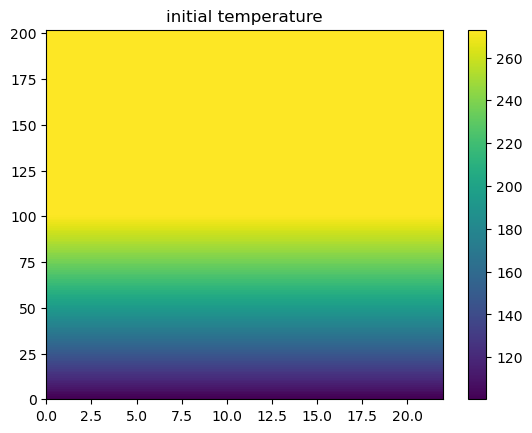

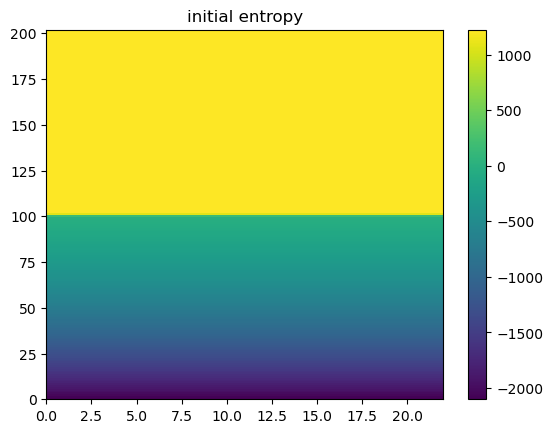

In [16]:
# setup the domain
options = Dict()
options["latent heat of fusion"] = 3.34e5 #J/kg
options["specific heat of ice"] = 2.1e3 # J/kg*K (ice)
options["density of ice"] = 1e3 # kg/m^3
options["thermal conductivity of ice"] = 2.2 # W/m*K
options["thermal diffusivity"] = options["thermal conductivity of ice"] / (options["density of ice"]*options["specific heat of ice"]) # m^2/s

options["Tm"] = 273.0 # K
options["To"] = 100.0 # K
options["ym"] = 1e3 # m 

W = 2e2
H = 2e3
ny = 201
nx = Int64( ceil(W/H*ny) )
gx = 0.0
gy = 0.113
markx = 6
marky = 6
seconds_in_year = 3.15e7

materials = Materials()
mygrid = CartesianGrid(W,H,nx,ny)
markers = Markers(mygrid,["alpha","T","rho","Cp","Hr","kThermal","S","X"],["material"] ; nmx=markx,nmy=marky,random=false)
@time initial_conditions!(markers,materials,options)

Tbctype = [-1,-1,1,1] #left, right, top, bottom
Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom

# compute lambda1 (see Turcotte and Schubert chapter on Stefan Problem) and the
# time corresponding to the initial ice shell thickness
lambda1 = get_lambda1(options)
ttmp = get_t(lambda1,options)

rho_c,Hr,kThermal, = marker_to_stag(markers,mygrid,["rho","Hr","kThermal",],"center")
kThermal_vx, = marker_to_stag(markers,mygrid,["kThermal",],"vx")
kThermal_vy, = marker_to_stag(markers,mygrid,["kThermal",],"vy")

# initialize arrays to hold quantities for plotting
ocean_ice_interface = []
append!(ocean_ice_interface,options["ym"])
plot_time = []
append!(plot_time,0.0)

# at the beginning of the computation, interpolate from the markers to the nodes and back.
Xlast,Tlast = marker_to_stag(markers,mygrid,["X","T"],"center")
rhoT = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["T"],:]
Slast, = marker_to_stag(markers,mygrid,["S"],"center",extra_weight=rhoT)
cell_center_to_markers!(markers,mygrid,Slast,"S")
update_marker_T_X!(markers,materials,options)

figure()
pcolor(Tlast)
title("initial temperature")
colorbar()
show()
figure()
pcolor(Slast)
colorbar()
title("initial entropy")
show()
T0 = copy(Tlast)
S0 = copy(Slast)

time = 0.0
iout=0
dt = calculate_diffusion_timestep(mygrid,options)

for itime in 1:10001
    Xlast,Tlast = marker_to_stag(markers,mygrid,["X","T"],"center")
    rhoT = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["T"],:]
    Slast, = marker_to_stag(markers,mygrid,["S"],"center",extra_weight=rhoT)

    Snew = copy(Slast)
    Tnew = copy(Tlast)
    Xnew = copy(Xlast)
    for titer in 1:300
        # Using Tlast yields an explicit scheme
        q_vx,q_vy = compute_q_cond(mygrid,Tlast,kThermal_vx,kThermal_vy) # W/m^2
        # Using Tlast yields an explicit scheme
        Snew = compute_S_new(mygrid,Tlast,rho_c,Hr,q_vx,q_vy,Slast,dt)
        Tnew,Xnew = update_T_X_from_S(Snew,options)             
        Tnew,Xnew,Snew = ghost_nodes_center_TXS(mygrid,Tnew,Xnew,Snew,Tbctype,Tbcval,options)
        residual = compute_entropy_residual(mygrid,Tlast,rho_c,Hr,q_vx,q_vy,Slast,Snew,dt)
        Snorm = norm( residual[2:ny,2:nx] )
        
        if Snorm < 1e-12
            println(itime,":",titer,":",Snorm)    
            break
        elseif titer == 100
            println("failed to converge")
            break
        end
    end
    
    dS = Snew - Slast
    # compute the subgrid entropy change
    dS_subgrid_node = subgirdSdiff!( mygrid,markers,Slast,dt,options,diffusivity=1.0 )
    dS_remaining = dS-dS_subgrid_node
    
    cell_center_change_to_markers!(markers,mygrid,dS_remaining,"S")
    update_marker_T_X!(markers,materials,options)

    #interface = get_interface(mygrid,-Snew,-611.0)
    interface = get_interface(mygrid,-Xnew,-0.5)
    append!(ocean_ice_interface,mean(interface))
    
    # advance to next timestep
    Slast = copy(Snew)
    Xlast = copy(Xnew)
    Tlast = copy(Tnew)

    if mod(itime,100) == 1
        output_dir = "max_debug8"
        if iout == 0
            mkdir(output_dir)
        end
        name1 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        println("Writing visualization file = ",name1)
        visualization(markers,time/seconds_in_year;filename=name1)                    
        
        name2 = @sprintf("%s/nodal_fields.%04d.vtr",output_dir,iout)
        output = Dict( "S"=>Snew[2:ny,2:nx],"X"=>Xnew[2:ny,2:nx],"T"=>Tnew[2:ny,2:nx])
        visualization(mygrid,output,time/seconds_in_year,filename=name2)
        
        iout+=1 
    end
    time += dt
    append!(plot_time,time)
end

1079.010266024368


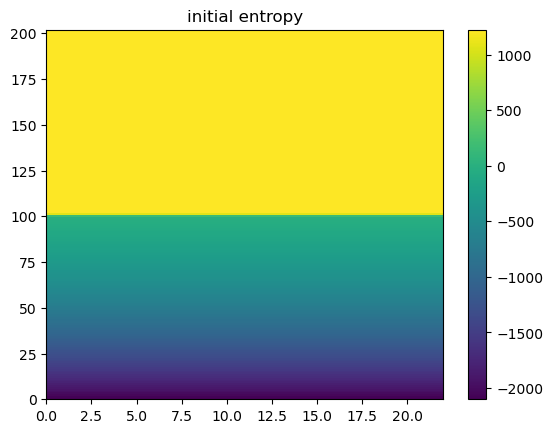

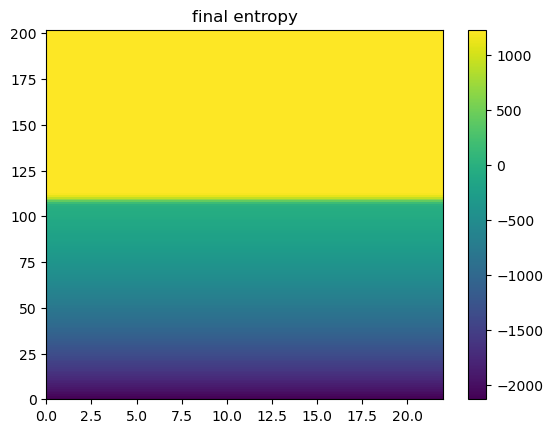

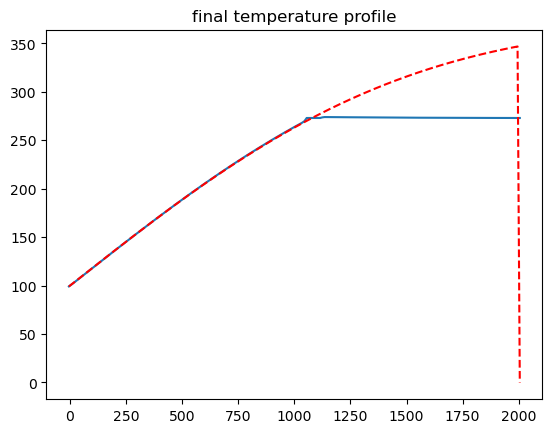

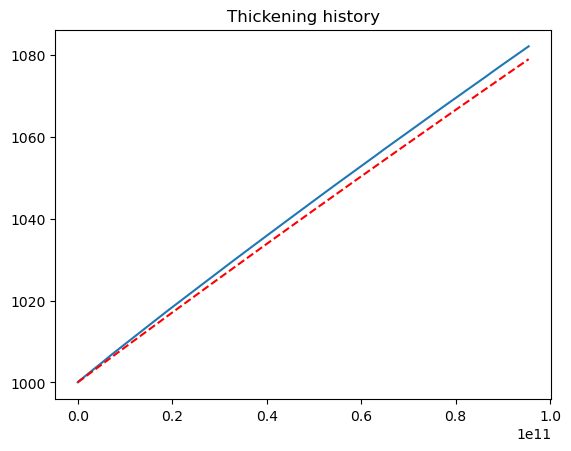

In [17]:
figure()
pcolor(S0)
colorbar()
title("initial entropy")
show()

figure()
pcolor(Slast)
colorbar()
title("final entropy")
show()

figure()
plot(mygrid.yc,Tlast[:,2])
title("final temperature profile")

final_time = ttmp + time
stefan_solution = zeros(ny+1,1)
for j in 1:mygrid.ny
    stefan_solution[j] = stefan_initial_condition( get_theta(mygrid.yc[j],final_time,lambda1),options)
end
plot(mygrid.yc,stefan_solution,"r--")
show()

yfinal = get_y.(lambda1,final_time,Ref(options))
println(yfinal)

figure()
plot(plot_time,ocean_ice_interface)
yfinal = get_y.(lambda1,plot_time .+ ttmp,Ref(options))
plot(plot_time,yfinal,"r--")
title("Thickening history")
show()